titanic feature enginering
作為Kaggle上ML最經典的入門案例，利用891個鐵達尼號乘客的資料來預測剩下4XX位乘客是否存活
讓我們來研究看看吧

在進入Deep Learning前，資料的前置處理是十分重要的
Outliner,Missing Data,甚至是篩選有用的features
對模型的參數調整與預測能力都是非常有幫助的

我們feature engineering的流程如下
一. 清理資料
    1. 檢視missing value，並依情況選擇impute的方式
    2. 查看資料的敘述統計與分配情形，作為transfrom data的參考
    3. 檢視outlier的情況
二. 特徵選擇
    1. 領域知識(Domain knowledge)
    2. 統計資料(在領域知識不足下，用統計數據來判斷哪些特徵對預測目標y較有用處)
三. 資料轉換
    1. 可以將數值資料進行加、減、平均、取log等(轉換以使資料的特徵更明顯，也可將數值資料轉換成類別資料)
    2. 將數值資料做normalization(資料的scale並不相同，且經過normalize後，其平均為0，資料有正有負，對於gradient discent的方向修正較為靈活)
    3. 將類別資料encoding成神經網路可學習的數值
    

In [1]:
import pandas as pd

train_path = '/Users/robert/Documents/ML_dataset/titanic/train.csv'

df = pd.read_csv(train_path)

df.shape

(891, 12)

In [2]:
df.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


從describle中可以看到891個samples中，只有38.38%的人存活
而age當中有891-714個missing data
在資料分散程度中，SibSp跟Parch的分散程度小 畢竟親人跟兄弟姐妹的數量不會太多，但船資的分散程度就很大了
而shape中可以看到有12個cols

In [5]:
df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [6]:
#看看哪些欄位有missing value
df.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

Age,Cabin,Embarked都有missing data
有missing data的特徵我們晚點再回去處理，

# Pclass
我們feature一個一個來分析吧
首先是第一個 Pclass >> 艙等
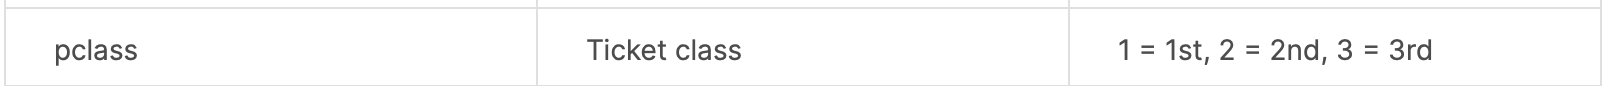

In [7]:
df['Pclass'].unique() #Pclass column中確實只有1,2,3種艙等

array([3, 1, 2])

In [8]:
#利用groupby來將所有1,2,3艙等的生存資料合併再一起，並對存活使否取平均
df[['Pclass','Survived']].groupby(['Pclass']).mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


我們可以發現，在頭等艙的乘客存活率為62%，次等艙位為47%，而最差的三等艙位存活率只有24%，故乘客屬於哪一個艙等對於預測是否存活可能為重要特徵
>Ho: 艙等基於位置或是乘客身份的優先不同，對於存活與否有顯著影響，為重要特徵
    (而與艙等有直接相關的Fare應該也同時對存活與否有影響)


# Sex
接著我們來看看Sex性別特徵

In [9]:
df['Sex'].unique()

array(['male', 'female'], dtype=object)

乘客性別資料也非常完整，但儲存的方式為string，需另外將其轉成數字
我們先來看看其與存活與否是否有相關吧


In [10]:
df[['Sex','Survived']].groupby(['Sex']).mean()

,Survived
Sex,
female,0.742038
male,0.188908


身為女性乘客的存活率比男性高上3倍以上，這是很明顯的差距，但這是否是因為男女在船上的比率失衡而造成的偏差
例如 100個乘客中 女生只有5個 有4個倖存 那女性的存活率就是4/5 = 80%，可能是樣本數過少而產生
我們需再看男女乘客在船上的比例

In [11]:
#先加男女改為數字 男:1 , 女:0 
#這樣加總就知道男女在船上的數量
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0}).astype(int)

In [12]:
men = df['Sex'].sum()
print(f'男乘客數: {men} 女乘客數: {len(df)- men}')

男乘客數: 577 女乘客數: 314


可以發現男性乘客約是女性乘客的1.5倍多，但女性乘客在樣本中約佔有35%，並非是因為樣本數極少而產生偏差

>Ho : 也許優先讓婦孺上救生艇，故女性的生存率明顯高於男性，性別為預測生存與否的重要特徵

# Age
再來我們來看看Age的部分

In [13]:
df['Age'].isnull().sum()

177

並不意外，在df.describe中只有count到714個樣本
有Age中177個missing value
面對大量missing value，除了刪除整個feature外，也可以使用推估的方式來填補missing 

In [14]:
#利用pd.cut 跟據1,11...91將不同年齡的人區隔出來
#並assign至age_cut dtypes:category
#再用此作依據將資料合併並求出不同年紀的生存率
#cut = [i for i in range(1,100,10)]
cut = [0,15,30,60,100]
age_cut = pd.cut(df['Age'],cut)
age_count = df['Age'].groupby(age_cut).count()
age_count

Age
(0, 15]       83
(15, 30]     326
(30, 60]     283
(60, 100]     22
Name: Age, dtype: int64

In [15]:
df['Survived'].groupby(age_cut).mean()

Age
(0, 15]      0.590361
(15, 30]     0.358896
(30, 60]     0.420495
(60, 100]    0.227273
Name: Survived, dtype: float64

我們來看看不同年齡的平均生存率

這也應證了我們先前的假設，婦孺們優先拯救，而老年的因身體較差，其存活率最低
至於missing data的處理我們先擱置，晚點再處理

In [16]:
age_missing_index = df[df['Age'].isnull()].index

# SibSp, Parch 以及其combine Family
再來我們來看看兄弟姐妹與父母數量特徵

In [17]:
df[['Age','SibSp','Parch']].corr()

,Age,SibSp,Parch
Age,1.000000,-0.308247,-0.189119
SibSp,-0.308247,1.000000,0.414838
Parch,-0.189119,0.414838,1.000000


從簡單的相關係數可以推測以下
兄弟姐妹的數量與年齡為負相關，與家長數量正相關>>整個家庭帶著小孩一起出遊
家長數量與年齡負相關>成年男女等已在外成家立業，未必會帶著年邁的父母。而中老年的乘客更是如此


我們將這兩個特徵合併(相加)，創造一個新的'Family'特徵
並用此對生存率做比較

In [18]:
df['Family'] = df['SibSp'] + df['Parch']
df[['Family','Survived']].groupby(['Family']).mean()

,Survived
Family,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


可以發現支身上船的乘客，平均存活率為30%
而有1~3個家人 其存活率超過50%以上
一但家人數為4人以上時，存活率卻驟降至20%以下，我猜測家人數超過4人的可能很少，也許是樣本太小造成的偏差
我們再進一步分析看看

In [19]:
df['Family'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: Family, dtype: int64

果然，家人3人以上的乘客非常少，若直接認定家人有3人的存活率為70%很可能會高估，也許我們該將家人3人以上的乘客們加總，再來比較存活率

In [20]:
#將家人數為3以上的都視爲3人
df['Family'] = df['Family'].apply(lambda x: 3 if x >= 3 else x)
df['Family'].value_counts()

0    537
1    161
2    102
3     91
Name: Family, dtype: int64

In [21]:
df[['Family','Survived']].groupby('Family').mean()

,Survived
Family,
0,0.303538
1,0.552795
2,0.578431
3,0.340659


看來家人只有1~2人的乘客存活率較高，而獨身一人以及家人數超過3人的乘客，其存活率約為30%

# Name, Ticket
再來是Name跟Ticket這兩個features，雖然都沒有missing value，
但我認為
Name上雖有稱謂，如Mr、Miss等，雖然對Age的missing value估計有幫助，但從Fare跟Family去估計也能得到不錯的效果(預處理最後會有對估計missing value的方式)
Ticket上的資訊反映了出發地點>>包含在Embarked跟Fare features中
故這兩2個features我想要drop掉

# Fare

In [22]:
df['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

<AxesSubplot:ylabel='Frequency'>

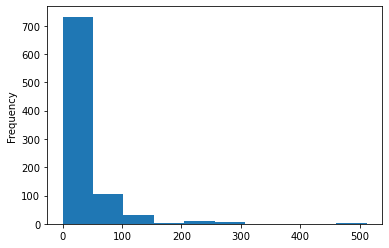

In [23]:
df['Fare'].sort_values().plot(kind = 'hist')

整個Fare全距很大，有少數極端值以及0元的，整個變異很大，為右尾分配
有0元的資料使得其不能使用log transfrom或是BoxCox transform
我認為Fare跟Pclass是直接有關聯的

In [24]:
df[['Pclass', 'Fare']].groupby('Pclass').mean()

,Fare
Pclass,
1,84.154687
2,20.662183
3,13.675550


既然這個特徵已經可以被pclass完全解釋，也許我們可以drop掉這個特徵

# Cabin

這個特徵有缺失值，先來看看其缺失值的數量

In [27]:
df['Cabin'].isnull().sum()

687

居然有687/891約77%的資料是缺失的，這個特徵所能提供的資訊很少

## 將採用的特徵如下：  
1. P_class 艙等(類別)
2. Sex 性別(類別)
3. Age 年齡(數值)
4. Family 家庭人數(類別，由父母與兄弟姐妹總數加總所得，並將人數超過3的視為一組)

我們將需要的特徵取出，並組成一個dataframe  


In [34]:
feature_df = df[['Pclass', 'Sex' ,'Age', 'Family', 'Survived']]
feature_df.dtypes

Pclass        int64
Sex           int64
Age         float64
Family        int64
Survived      int64
dtype: object

我們將類別變數做One-hot encoding  
這樣處理的理由如下  
今天Pclass的艙位分別為1,2,3  
若我直接丟入模型做訓練，這樣1,2,3隱含著。
1等艙跟2等艙的關係較1等艙與3等艙較接近，但事實上是彼此皆為獨立，並沒有這一層關聯  


pandas中，要做One-hot encoding很簡單，只要呼叫`get_dummy()`這個function就好  
然而這只接受dtype為str或是dict的資料型態  
故我們先進行以下的轉換。

In [42]:
feature_df.astype({'Pclass': str,'Sex': str, 'Family': str}).dtypes

Pclass       object
Sex          object
Age         float64
Family       object
Survived      int64
dtype: object

In [48]:
feature_df = pd.get_dummies(feature_df)
feature_df

,Age,Survived,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Family_0,Family_1,Family_2,Family_3
0,22.0,0,0,0,1,0,1,0,1,0,0
1,38.0,1,1,0,0,1,0,0,1,0,0
2,26.0,1,0,0,1,1,0,1,0,0,0
3,35.0,1,1,0,0,1,0,0,1,0,0
4,35.0,0,0,0,1,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
886,27.0,0,0,1,0,0,1,1,0,0,0
887,19.0,1,1,0,0,1,0,1,0,0,0
888,NaN,0,0,0,1,1,0,0,0,0,1
889,26.0,1,1,0,0,0,1,1,0,0,0


# 別忘了在訓練模型之前的空值整理

In [49]:
feature_df.isnull().any()

Age          True
Survived    False
Pclass_1    False
Pclass_2    False
Pclass_3    False
Sex_0       False
Sex_1       False
Family_0    False
Family_1    False
Family_2    False
Family_3    False
dtype: bool

In [50]:
feature_df['Age'].isnull().sum()

177

只有age中有空值，且有177個空值  
又age為重要變數，不能輕易drop掉，若單純用平均數去推測missing data  
會使預測的變異性下降(平均數無法為模型提供變異的預測功能，但多出的data會使得模型變異較小)  
我們使用KMMimpute的方式去預測  

In [57]:
missing_index = feature_df[feature_df['Age'].isnull()].index

In [ ]:
from sklearn.impute import KNNImputer

In [65]:
imputer = KNNImputer(n_neighbors=4)

# 主觀認定年齡和'Pclass','Family'這2個變數較有關聯
feature_df['Age'] = imputer.fit_transform(feature_df)


In [66]:
feature_df.loc[missing_index, 'Age']

5      32.0
17     36.5
19     18.0
26     32.0
28     18.0
       ... 
859    32.0
863    29.5
868    32.0
878    32.0
888    29.5
Name: Age, Length: 177, dtype: float64

In [157]:
feature_df.isnull().any()

Age         False
Survived    False
Pclass_1    False
Pclass_2    False
Pclass_3    False
Sex_0       False
Sex_1       False
Family_0    False
Family_1    False
Family_2    False
Family_3    False
dtype: bool

已經處理完missing data了  
接著我們來用ML做預測吧。
分類問題中，在小樣本表現很好的SVM  


In [150]:
from sklearn.pipeline import Pipeline  # 建立資料轉換的流程，以免出錯
from sklearn.model_selection import train_test_split # 用來拆分train, test的data
from sklearn.preprocessing import StandardScaler # 將資料進行標準化，以增加訓練的速度與精確度
from sklearn.metrics import confusion_matrix # 資料訓練完後，檢視模型的預測表現
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA # 降維
from sklearn.svm import SVC # SVM本體


In [151]:
# 將資料轉換的流程用pipeline包住，可以確保不會有data leak的情況，也就是test set的data在做cross_validation 被拿去訓練，進而影響模型預測
estimators = [('scaler', StandardScaler()),  ('svm', SVC())]
# 先拿掉PCA ('reduce_dim', PCA()),
pipe = Pipeline(estimators)
pipe

Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC())])

In [152]:
# 可以用step來確認整個資料轉換的流程
pipe.steps[1]

('svm', SVC())

In [153]:
X = train_data.drop('Survived', axis = 1)
y = train_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y,  random_state=666, train_size=0.7)
print(X_train)
print(y_train)

      Age  Pclass_1  Pclass_2  Pclass_3  Sex_0  Sex_1  Family_0  Family_1  \
488  30.0         0         0         1      0      1         1         0   
487  58.0         1         0         0      0      1         1         0   
830  15.0         0         0         1      1      0         0         1   
245  44.0         1         0         0      0      1         0         0   
94   59.0         0         0         1      0      1         1         0   
..    ...       ...       ...       ...    ...    ...       ...       ...   
452  30.0         1         0         0      0      1         1         0   
81   29.0         0         0         1      0      1         1         0   
115  21.0         0         0         1      0      1         1         0   
504  16.0         1         0         0      1      0         1         0   
617  26.0         0         0         1      1      0         0         1   

     Family_2  Family_3  
488         0         0  
487         0         0

In [154]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC())])

In [155]:
# test data的正確率
pipe.score(X_test, y_test)

0.8457943925233645

array([1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0])

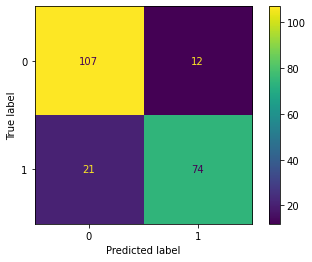

In [128]:
plot_confusion_matrix(pipe, X_test, y_test, values_format = 'd')

In [183]:
param_grid = [
    {'svm__C':[0.5,1,10,100],
    'svm__gamma':['scale',1, 0.1, 0.01, 0.001, 0.0001],
     'svm__kernel':['rbf']
    }    
]

opt_params = GridSearchCV(
    pipe,
    param_grid = param_grid,
    cv = 5,
    scoring = 'accuracy',
    #verbose =2 
)

opt_params.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('svm', SVC())]),
             param_grid=[{'svm__C': [0.5, 1, 10, 100],
                          'svm__gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
                          'svm__kernel': ['rbf']}],
             scoring='accuracy')

In [184]:
print(opt_params.best_params_)

{'svm__C': 10, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}


In [185]:
adjust_pipe = Pipeline( [('scaler', StandardScaler()),  ('svm', SVC( C = 10, gamma = 'scale'))] )


In [176]:
adjust_pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svm', SVC(C=10))])

In [178]:
adjust_pipe.score(X_test, y_test)

0.8598130841121495

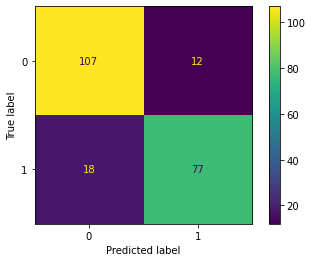

In [180]:
plot_confusion_matrix(adjust_pipe, X_test, y_test, values_format = 'd')